In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skfda import FDataGrid
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import BSplineBasis
from skfda.preprocessing.smoothing import BasisSmoother
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import StandardScaler
from sktime.transformations.panel.rocket import Rocket

In [45]:
def pad_with_last_row(series, fixed_rows):
    series = np.array(series)
    current_rows, columns = series.shape
    if current_rows > fixed_rows:
        return series[:fixed_rows, :]
    elif current_rows < fixed_rows:
        last_row = series[-1, :]
        padding = np.tile(last_row, (fixed_rows - current_rows, 1))
        return np.vstack((series, padding))
    return series

def load_segmented_time_series(input_dir, max_len=11):
    x_data, y_data = [], []
    for file_name in os.listdir(input_dir):
        if file_name.endswith('.csv') and file_name != 'multivariate_time_series.csv':
            class_label = file_name.split('_')[0]
            df = pd.read_csv(os.path.join(input_dir, file_name))
            time_series = df.iloc[:, 3:].values
            time_series = pad_with_last_row(time_series, max_len)
            x_data.append(time_series)
            y_data.append(class_label)
    return np.array(x_data), np.array(y_data)

def load_univariate_series(input_dir, keypoint='LEFT_ELBOW', coord='y', max_len=11):
    x_data, y_data = [], []
    col = f"{keypoint}_{coord}"
    for fn in os.listdir(input_dir):
        if not fn.endswith('.csv'):
            continue
        df = pd.read_csv(os.path.join(input_dir, fn))
        series = df[col].values.reshape(-1, 1)            # (timepoints, 1)
        series = pad_with_last_row(series, max_len)      # pad to fixed length
        x_data.append(series)                            # 각 샘플당 (max_len, 1)
        y_data.append(fn.split('_')[0])
    return np.array(x_data), np.array(y_data)            # shape: (n_samples, max_len, 1)

def to_fd_list(x_data, apply_smoothing=False, n_basis=7):
    fd_list = [FDataGrid(data_matrix=sample.T, grid_points=np.linspace(0, 1, sample.shape[0])) for sample in x_data]
    if apply_smoothing:
        basis = BSplineBasis(n_basis=n_basis)
        smoother = BasisSmoother(basis=basis)
        fd_list = [smoother.fit_transform(fd) for fd in fd_list]
    return fd_list

In [13]:
fd_smooth.data_matrix.shape

(5296, 300, 36)

In [55]:
segment_dir = "/Users/junokim/Desktop/jupyteryong2/slr/peak_detection_results/segments2"
# 1) 데이터 로드 + 패딩
x_data, y_data = load_segmented_time_series(segment_dir, max_len=300)

# 2) 함수형 객체로 변환 + 스무딩
grid = np.linspace(0, 1, 200)
fd = FDataGrid(data_matrix=x_data, grid_points=[grid])
smoother = BasisSmoother(basis=BSplineBasis(n_basis=20))
fd_smooth = smoother.fit_transform(fd)

# 3) numpy로 꺼내서 축 순서 맞추기
#    original: (n_samples, timepoints, features)
# ROCKET expects: (n_samples, channels, timepoints)
X = np.transpose(fd_smooth.data_matrix, (0, 1, 2))

# 4) train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_data, test_size=0.2, stratify=y_data, random_state=42
)

# 5) ROCKET 변환 + Ridge 분류
rocket = Rocket(num_kernels=5000, normalise=False)
rocket.fit(X_train)
X_train_tr = rocket.transform(X_train)
X_test_tr  = rocket.transform(X_test)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_tr)
X_test_scaled  = scaler.transform(X_test_tr)

clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf.fit(X_train_scaled, y_train)

# 6) 평가
y_pred = clf.predict(X_test_scaled)
print("ROCKET + FDA Accuracy:", accuracy_score(y_test, y_pred))

# 7) 모델 저장
model_bundle = {
    "rocket": rocket,
    "scaler": scaler,
    "classifier": clf,
    "smoother": smoother,
    "grid": grid
}

with open("rocket_fda_model.pkl", "wb") as f:
    pickle.dump(model_bundle, f)

ROCKET + FDA Accuracy: 0.8207547169811321


In [56]:
from sklearn.metrics import classification_report

# y_test와 y_pred를 기반으로 precision, recall, f1-score 출력
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

         377     0.7692    0.8108    0.7895        37
         378     0.7241    0.6774    0.7000        31
         379     0.8378    0.8378    0.8378        37
         380     0.8214    0.7667    0.7931        30
         381     0.8571    0.8000    0.8276        30
         382     0.8261    0.7308    0.7755        26
         383     0.7105    0.7105    0.7105        38
         384     0.8571    0.7742    0.8136        31
         385     0.8158    0.9118    0.8611        34
         386     0.8750    0.8750    0.8750        32
         387     0.8235    0.8235    0.8235        34
         388     0.8889    0.8000    0.8421        30
         389     0.7500    0.6857    0.7164        35
         390     0.9333    0.9655    0.9492        29
         391     0.7250    0.8056    0.7632        36
         392     0.8000    0.8750    0.8358        32
         393     0.7826    0.5806    0.6667        31
   

In [59]:
from sktime.transformations.panel.rocket import MultiRocket
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pickle

segment_dir = "/Users/junokim/Desktop/jupyteryong2/slr/peak_detection_results/segments2"
# 1) 데이터 로드 + 패딩
x_data, y_data = load_segmented_time_series(segment_dir, max_len=200)

# 2) 함수형 객체로 변환 + 스무딩
grid = np.linspace(0, 1, 200)
fd = FDataGrid(data_matrix=x_data, grid_points=[grid])
smoother = BasisSmoother(basis=BSplineBasis(n_basis=20))
fd_smooth = smoother.fit_transform(fd)

# 3) numpy로 꺼내서 축 순서 맞추기
#    original: (n_samples, timepoints, features)
# ROCKET expects: (n_samples, channels, timepoints)
X = np.transpose(fd_smooth.data_matrix, (0, 1, 2))

# 4) train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_data, test_size=0.2, stratify=y_data, random_state=42
)

# 5) MultiROCKET 변환 + Ridge 분류
rocket = MultiRocket(num_kernels=200, n_jobs=-1)  # 보통 MultiROCKET은 더 많은 커널을 사용
rocket.fit(X_train)
X_train_tr = rocket.transform(X_train)
X_test_tr  = rocket.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_tr)
X_test_scaled  = scaler.transform(X_test_tr)

clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf.fit(X_train_scaled, y_train)

# 6) 평가
y_pred = clf.predict(X_test_scaled)
print("MultiROCKET + FDA Accuracy:", accuracy_score(y_test, y_pred))

# # 7) 모델 저장
# model_bundle = {
#     "rocket": rocket,
#     "scaler": scaler,
#     "classifier": clf,
#     "smoother": smoother,
#     "grid": grid
# }

# with open("multirocket_fda_model.pkl", "wb") as f:
#     pickle.dump(model_bundle, f)

MultiROCKET + FDA Accuracy: 0.8245283018867925


In [58]:
from sklearn.metrics import classification_report

# y_test와 y_pred를 기반으로 precision, recall, f1-score 출력
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

         377     0.8649    0.8649    0.8649        37
         378     0.7000    0.6774    0.6885        31
         379     0.8378    0.8378    0.8378        37
         380     0.9259    0.8333    0.8772        30
         381     0.8276    0.8000    0.8136        30
         382     0.7917    0.7308    0.7600        26
         383     0.7297    0.7105    0.7200        38
         384     0.9600    0.7742    0.8571        31
         385     0.7632    0.8529    0.8056        34
         386     0.8485    0.8750    0.8615        32
         387     0.9655    0.8235    0.8889        34
         388     0.7812    0.8333    0.8065        30
         389     0.8485    0.8000    0.8235        35
         390     0.7714    0.9310    0.8438        29
         391     0.7297    0.7500    0.7397        36
         392     0.7073    0.9062    0.7945        32
         393     0.8571    0.5806    0.6923        31
   

In [19]:
from skfda.representation.basis import FourierBasis

segment_dir = "/Users/junokim/Desktop/jupyteryong2/slr/peak_detection_results/segments2"
# 1) 데이터 로드 + 패딩
x_data, y_data = load_segmented_time_series(segment_dir, max_len=300)

# 2) 함수형 객체로 변환 + 스무딩
grid = np.linspace(0, 1, 300)
fd = FDataGrid(data_matrix=x_data, grid_points=[grid])
smoother = BasisSmoother(basis=FourierBasis(domain_range=(0, 1), n_basis=20))
fd_smooth = smoother.fit_transform(fd)

# 3) numpy로 꺼내서 축 순서 맞추기
#    original: (n_samples, timepoints, features)
# ROCKET expects: (n_samples, channels, timepoints)
X = np.transpose(fd_smooth.data_matrix, (0, 1, 2))

# 4) train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_data, test_size=0.2, stratify=y_data, random_state=42
)

# 5) ROCKET 변환 + Ridge 분류
rocket = Rocket(num_kernels=5000, normalise=False)
rocket.fit(X_train)
X_train_tr = rocket.transform(X_train)
X_test_tr  = rocket.transform(X_test)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_tr)
X_test_scaled  = scaler.transform(X_test_tr)

clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf.fit(X_train_scaled, y_train)

# 6) 평가
y_pred = clf.predict(X_test_scaled)
print("ROCKET + FDA Accuracy:", accuracy_score(y_test, y_pred))

# 7) 모델 저장
model_bundle = {
    "rocket": rocket,
    "scaler": scaler,
    "classifier": clf,
    "smoother": smoother,
    "grid": grid
}

with open("rocket_fda_model.pkl", "wb") as f:
    pickle.dump(model_bundle, f)

ROCKET + FDA Accuracy: 0.8009433962264151


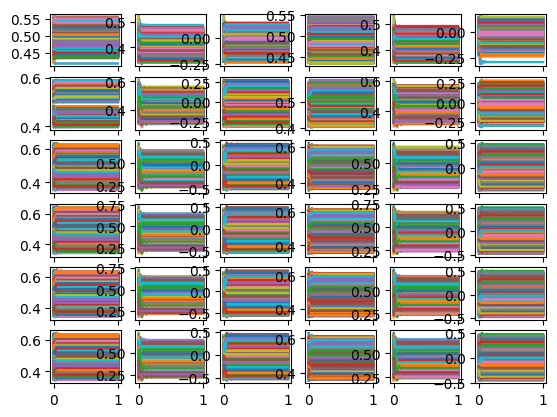

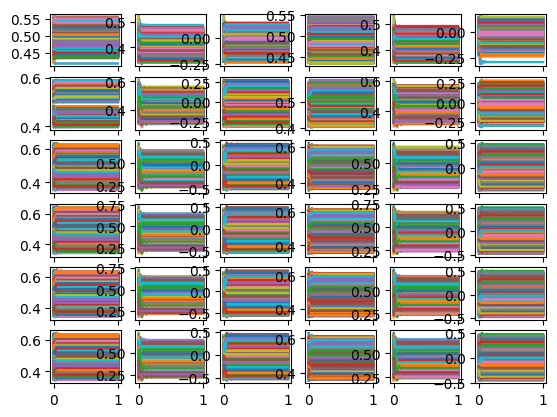

In [51]:
fd_smooth.plot()

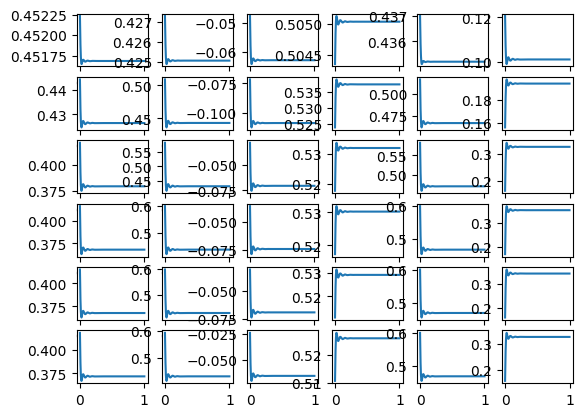

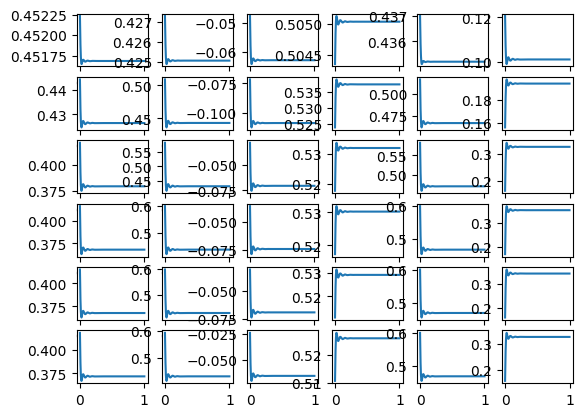

In [50]:
fd_smooth[0].plot()

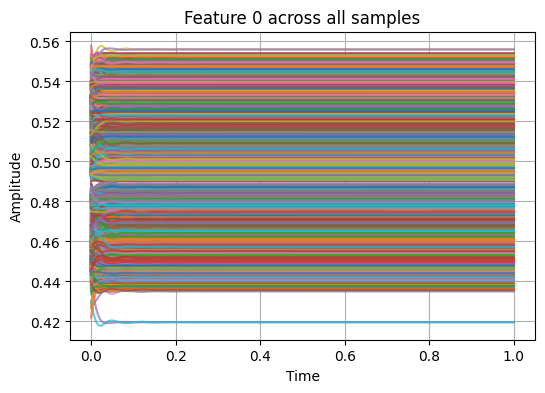

In [49]:
import matplotlib.pyplot as plt

feature_index = 0  # 첫 번째 feature
x = fd_smooth.grid_points[0]  # 공통 grid
n_samples = fd_smooth.data_matrix.shape[0]

plt.figure(figsize=(6, 4))
for i in range(n_samples):
    y = fd_smooth.data_matrix[i, :, feature_index]
    plt.plot(x, y, alpha=0.7)

plt.title(f"Feature {feature_index} across all samples")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [ ]:
# 1) 세그먼트 로드
segment_dir = "/Users/junokim/Desktop/jupyteryong2/slr/peak_detection_results/segments2"
x_data, y_data = load_segmented_time_series(segment_dir, max_len=11)

# FDataGrid로 변환
x_data = np.array(x_data)
x_data = np.transpose(x_data, (0, 2, 1))  # (samples, features, timesteps)

In [ ]:
print("x_data shape:", x_data.shape)
print("Example entry shape:", x_data[0].shape)

x_data shape: (5296, 300, 36)
Example entry shape: (300, 36)


In [2]:
print(x_data.shape[2])

NameError: name 'x_data' is not defined

In [49]:
test_dir = "/Users/junokim/Desktop/jupyteryong2/slr/test"
predictions = []

for file_name in os.listdir(test_dir):
    if file_name.endswith('.csv'):
        df = pd.read_csv(os.path.join(test_dir, file_name))
        time_series = df.iloc[:, 3:].values
        time_series = pad_with_last_row(time_series, fixed_rows=11)
        fd = FDataGrid(data_matrix=time_series.T, grid_points=np.linspace(0, 1, 11))
        basis = BSplineBasis(n_basis=7)
        smoother = BasisSmoother(basis=basis)
        fd = smoother.fit_transform(fd)
        pred = model.predict([fd])[0]
        predictions.append((file_name, pred))

label_meaning = {
    '377': '올바른 사이드 레터럴 레이즈 자세',
    '378': '무릎 반동이 있는 자세',
    '379': '어깨 으쓱하는 자세',
    '380': '상완/전완 각도 고정 안된 자세',
    '381': '손목 각도 고정 안된 자세',
    '382': '상체 반동이 있는 자세'
}

for fname, label in predictions:
    print(f"{fname} → {label} ({label_meaning.get(label, '알 수 없음')})")

In [ ]:
import numpy as np
from skfda import FDataGrid
from sklearn.decomposition import PCA

def mfpca_via_univariate(fd: FDataGrid,
                         n_components_global: int,
                         n_components_univariate: int):
    """
    간단 MFPCA 구현: 각 차원별로 FPCA → 스코어 병합 → PCA
    
    Parameters
    ----------
    fd : FDataGrid
        data_matrix shape = (n_samples, n_timepoints, n_features)
    n_components_global : int
        최종 PCA 성분 개수 (MFPCA 축 개수)
    n_components_univariate : int
        각 차원별 FPCA에서 뽑을 성분 개수
        
    Returns
    -------
    fps : list of FPCA
        각 피처별 FPCA 객체
    pca : PCA
        스코어 병합 후 적용된 전역 PCA 객체
    global_scores : ndarray, shape (n_samples, n_components_global)
        최종 MFPCA 점수
    """
    # 1) Univariate FPCA for each feature
    n_samples, n_timepoints, n_features = fd.data_matrix.shape
    grids = fd.grid_points[0]  # length = n_timepoints

    fps = []
    scores_list = []
    for j in range(n_features):
        # j번째 feature만 골라 FDataGrid 생성
        data_j = fd.data_matrix[:, :, j]           # (n_samples, n_timepoints)
        fd_j   = FDataGrid(data_matrix=data_j,     # FDataGrid expects shape (samples, timepoints)
                           grid_points=[grids])
        fpca_j = FPCA(n_components=n_components_univariate)
        fpca_j.fit(fd_j)
        scores_j = fpca_j.transform(fd_j)         # (n_samples, n_components_univariate)
        
        fps.append(fpca_j)
        scores_list.append(scores_j)
    
    # 2) 스코어 병합
    # shape → (n_samples, n_features * n_components_univariate)
    S = np.hstack(scores_list)
    
    # 3) Global PCA (MFPCA)
    pca = PCA(n_components=n_components_global)
    global_scores = pca.fit_transform(S)
    
    return fps, pca, global_scores

In [ ]:
class FtsClassifier:
    def __init__(self, n_components=5):
        self.classifiers_mapping = {}
        self.n_components = n_components

    def fit(self, fd_train, y_train):
        fpca = FPCA(n_components=self.n_components)
        fpca.fit(fd_train)
        scores = fpca.transform(fd_train)
        clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
        clf.fit(scores, y_train)
        self.classifiers_mapping['fpca'] = fpca
        self.classifiers_mapping['classifier'] = clf

    def predict(self, fd_list):
        fpca = self.classifiers_mapping['fpca']
        clf = self.classifiers_mapping['classifier']
        scores = fpca.transform(fd_list)
        return clf.predict(scores)

    def evaluate(self, fd_test, y_test):
        y_pred = self.predict(fd_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"📊 Accuracy: {acc:.4f}")
        print("🧮 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print("📝 Classification Report:\n", classification_report(y_test, y_pred))
        return acc

In [ ]:
from fts_data_utils import load_segmented_time_series, pad_with_last_row
from skfda import FDataGrid
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.representation.basis import BSplineBasis
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1) 데이터 로드
x_data, y_data = load_segmented_time_series("/Users/junokim/Desktop/jupyteryong2/slr/peak_detection_results/segments2", max_len=11)
# x_data.shape = (n_samples, 11, n_features)

# 2) 함수형 객체로 변환 + 스무딩
grid = np.linspace(0, 1, 11)
fd_all = FDataGrid(data_matrix=x_data, grid_points=[grid])
smoother = BasisSmoother(basis=BSplineBasis(n_basis=30))
fd_all = smoother.fit_transform(fd_all)

# 3) train/test split
idx = np.arange(len(y_data))
tr, te, y_tr, y_te = train_test_split(idx, y_data, test_size=0.2, stratify=y_data)
fd_tr, fd_te = fd_all[tr], fd_all[te]

# 4) MFPCA via univariate
fps, pca, X_tr = mfpca_via_univariate(fd_tr,
                                      n_components_global=300,
                                      n_components_univariate=10)
X_te = pca.transform(np.hstack([
    fps[j].transform(FDataGrid(fd_te.data_matrix[:,:,j], [grid]))
    for j in range(fd_te.data_matrix.shape[2])
]))

# 5) 분류기 학습/평가
clf = RidgeClassifierCV(alphas=np.logspace(-3,3,10))
clf.fit(X_tr, y_tr)
y_pred = clf.predict(X_te)
print("Accuracy:", accuracy_score(y_te, y_pred))

Accuracy: 0.2009433962264151


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# … (앞 부분은 그대로) …

# 4) MFPCA via univariate
fps, pca, X_tr = mfpca_via_univariate(
    fd_tr,
    n_components_global=300,
    n_components_univariate=10
)
X_te = pca.transform(np.hstack([
    fps[j].transform(
        FDataGrid(fd_te.data_matrix[:, :, j], [grid])
    )
    for j in range(fd_te.data_matrix.shape[2])
]))

# 5) Grid Search + SVM 분류기 학습/평가
# --------------------------------------
# 파이프라인 정의
pipeline = Pipeline([
    ("scaler", StandardScaler()),            # 스코어 정규화
    ("svc",    SVC(kernel="rbf", class_weight="balanced"))
])

# 탐색할 하이퍼파라미터 그리드
param_grid = {
    "svc__C":     [0.1, 1, 10],
    "svc__gamma": ["scale", 0.01, 0.1],
}

# 5겹 교차검증 GridSearchCV
grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=1,        # 멀티코어 병렬화
    verbose=1
)

# 학습
grid.fit(X_tr, y_tr)

# 최고 파라미터와 CV 점수 출력
print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

# 테스트 세트 성능
test_acc = grid.score(X_te, y_te)
print("Test accuracy:", test_acc)

AssertionError: 

In [16]:
from skfda import FDataGrid
from skfda.representation.basis import BSplineBasis
from skfda.preprocessing.smoothing import BasisSmoother
import numpy as np

segment_dir = "/Users/junokim/Desktop/jupyteryong2/slr/peak_detection_results/segments2"
# 1) 데이터 로드 + 패딩
x_data, y_data = load_segmented_time_series(segment_dir, max_len=100)

# x_data.shape = (n_samples, timepoints, n_features)
grid = np.linspace(0, 1, 100)

# 1-1) FDataGrid 생성
fd = FDataGrid(data_matrix=x_data, grid_points=[grid])

# 1-2) (선택) B-spline 스무딩
basis    = BSplineBasis(n_basis=9)
smoother = BasisSmoother(basis=basis)
fd_smooth = smoother.fit_transform(fd)

from skfda.preprocessing.dim_reduction import FPCA
from sklearn.decomposition import PCA

def mfpca_via_univariate(fd, n_univ=5, n_global=20):
    # fd.data_matrix.shape == (n_samples, timepoints, n_features)
    n_features = fd.data_matrix.shape[2]
    grids      = fd.grid_points[0]

    # 2-1) 각 피처별 FPCA → 스코어 계산
    fps = []
    scores = []
    for j in range(n_features):
        # j번째 채널만 뽑아 FDataGrid 객체 생성
        fd_j = FDataGrid(data_matrix=fd.data_matrix[:, :, j],
                         grid_points=[grids])
        fpca_j = FPCA(n_components=n_univ)
        fpca_j.fit(fd_j)
        S_j = fpca_j.transform(fd_j)             # (n_samples, n_univ)
        fps.append(fpca_j)
        scores.append(S_j)

    # 2-2) 스코어 합치기 → (n_samples, n_features*n_univ)
    import numpy as np
    S = np.hstack(scores)

    # 2-3) Global PCA → (n_samples, n_global)
    pca = PCA(n_components=n_global)
    G = pca.fit_transform(S)

    return fps, pca, G

# 실행 예시
fps, pca, X = mfpca_via_univariate(fd_smooth,
                                   n_univ=8,
                                   n_global=30)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score

# 3-1) train/test split
idx = np.arange(len(y_data))
tr, te, y_tr, y_te = train_test_split(idx, y_data, test_size=0.2,
                                      stratify=y_data, random_state=42)
X_tr, X_te = X[tr], X[te]

# 3-2) RidgeClassifierCV (또는 원하는 분류기)
clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf.fit(X_tr, y_tr)

# 3-3) 평가
y_pred = clf.predict(X_te)
print("Accuracy:", accuracy_score(y_te, y_pred))

Accuracy: 0.14433962264150943


In [8]:
# 1) 세그먼트 로드: multivariate (모든 관절 xyz)
segment_dir = "/Users/junokim/Desktop/jupyteryong2/slr/peak_detection_results/segments2"
# load_segmented_time_series: 각각 (timepoints, features) 형태로 반환
x_data, y_data = load_segmented_time_series(segment_dir, max_len=11)

# x_data.shape == (n_samples, 11, n_features)
# 2) FDataGrid 생성 (multivariate codomain)
grid = np.linspace(0, 1, 11)              # 시간 정규화
fd = FDataGrid(data_matrix=x_data,       # (n_samples, timepoints, features)
               grid_points=[grid])       # 단일 도메인

# 3) 스무딩 (옵션)
basis    = BSplineBasis(n_basis=9)
smoother = BasisSmoother(basis=basis)
fd_smooth = smoother.fit_transform(fd)

# 4) 학습/테스트 분리
idx = np.arange(len(y_data))
train_idx, test_idx, y_train, y_test = train_test_split(
    idx, y_data, test_size=0.2, stratify=y_data, random_state=42
)
fd_train = fd_smooth[train_idx]
fd_test  = fd_smooth[test_idx]

# 5) MFPCA + RidgeClassifier 학습
n_components = 15
mfpca = MFPCA(n_components=n_components)
mfpca.fit(fd_train)

# 각 sample을 주성분 점수(feature)로 변환
X_train_scores = mfpca.transform(fd_train)
X_test_scores  = mfpca.transform(fd_test)

# 분류기 학습
clf = RidgeClassifierCV(alphas=np.logspace(-3,3,10))
clf.fit(X_train_scores, y_train)

# 6) 평가
y_pred = clf.predict(X_test_scores)
print("▶ Test Accuracy:", accuracy_score(y_test, y_pred))
print("▶ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("▶ Classification Report:\n", classification_report(y_test, y_pred))

# 7) 저장
model = {"mfpca": mfpca, "classifier": clf}
with open("lateralraise_mfpca.pkl", "wb") as f:
    pickle.dump(model, f)

AttributeError: 'FDataGrid' object has no attribute 'data'